In [16]:
!pip install qiskit==0.8.0
!pip install qiskit-aqua==0.4.0

# クラスタリングを離散最適化に

2次元データの$\{x_i\}_{i=1}^N$があるとします。

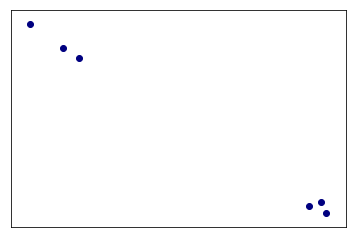

In [2]:
import numpy as np
import qiskit
import qiskit_aqua
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
π = np.pi
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

# Generating the data
c1 = np.random.rand(3, 2)/5
c2 = (-0.6, 0.5) + np.random.rand(3, 2)/5
data = np.concatenate((c1, c2))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:, 0], data[:, 1], color='navy')

教師なしタスクはこの構造を識別することです。問題は、量子ビットの数やそれらの接続に比べて多数の点がある場合、問題を解決できないことです。そのため、ユークリッド距離を使用して問題をmax-cutにマッピングするという考え方に盲目的に従い、その後、何らかの量子最適化法によってそれを解くと、この問題に対するキュービット接続が不足することになります。

しかし、距離を古典的に計算する方法についてスマートにすることを選択できます。これは一般的なトリックです：とにかく私達はハイブリッドの古典的 - 量子アルゴリズムをやっているので、私達は同様に古典的な部分をスマートにするかもしれません。 この場合、データセット内の距離を把握するために、何らかの形の[探索的データ分析]（https://en.wikipedia.org/wiki/Exploratory_data_analysis）に依存する可能性があります。

二次元データをプロットしたばかりなので、これは簡単なケースです。

blob内の密度が高いことがわかります。

距離をしきい値処理することで、作業を簡単にすることができます。 ユークリッド距離を距離関数として使用し、閾値以下の距離は切り捨てます。

しきい値は、ブロブ内のすべての距離がゼロに設定されるようにする必要があります。対称距離行列を、wと呼ばれる2次元のでこぼこの配列に格納します。

In [4]:
import itertools

n_instances = data.shape[0]
blob = 0.3
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])
    if (w[i, j] < blob):
        w[i, j] = 0
        
labels = np.array([0, 0, 0, 1, 1, 1])

print( (w[labels==0][:, labels==0]==0).sum() )
print( (w[labels==1][:, labels==1]==0).sum() )
w

9
9


array([[0.   , 0.   , 0.   , 0.821, 0.675, 0.72 ],
       [0.   , 0.   , 0.   , 0.851, 0.705, 0.75 ],
       [0.   , 0.   , 0.   , 0.811, 0.665, 0.71 ],
       [0.821, 0.851, 0.811, 0.   , 0.   , 0.   ],
       [0.675, 0.705, 0.665, 0.   , 0.   , 0.   ],
       [0.72 , 0.75 , 0.71 , 0.   , 0.   , 0.   ]])

# QAOAによってmax-cut問題を解く

ここから、max-cutをイジングハミルトニアンとして作成し、アニーリングまたはQAOAのような変分回路のいずれかで解くことは、かなり公式的です。

選択したフレームワークと最適化関数を使ってQAOA問題を設定します。


In [0]:
p = 1
from qiskit_aqua import get_aer_backend, QuantumInstance
from qiskit_aqua.algorithms import QAOA
from qiskit_aqua.components.optimizers import COBYLA
from qiskit_aqua.translators.ising import maxcut

qubit_operators, offset = maxcut.get_maxcut_qubitops(w)
optimizer = COBYLA()
qaoa = QAOA(qubit_operators, optimizer, p, operator_mode='matrix')

QAOAアルゴリズムで$ p = 1 $を設定し、max-cut問題で初期化します。

シミュレータでQAOAを実行します。

In [10]:
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)
result = qaoa.run(quantum_instance) # めっちゃ時間かかる
result

{'eigvals': array([-1.291]),
 'eigvecs': array([[-0.008-0.021j, -0.046-0.061j, -0.047-0.058j, -0.102+0.033j,
         -0.046-0.061j, -0.086+0.031j, -0.098+0.032j, -0.4  -0.073j,
         -0.05 -0.053j, -0.065+0.043j, -0.067+0.048j, -0.088+0.119j,
         -0.064+0.042j, -0.086+0.121j, -0.087+0.119j, -0.064+0.027j,
         -0.045-0.064j, -0.054+0.022j, -0.056+0.026j, -0.094+0.112j,
         -0.053+0.02j , -0.092+0.114j, -0.093+0.113j, -0.121+0.033j,
         -0.103+0.032j, -0.092+0.115j, -0.091+0.117j, -0.056+0.027j,
         -0.092+0.115j, -0.059+0.033j, -0.057+0.029j, -0.045-0.062j,
         -0.045-0.062j, -0.057+0.029j, -0.059+0.033j, -0.092+0.115j,
         -0.056+0.027j, -0.091+0.117j, -0.092+0.115j, -0.103+0.032j,
         -0.121+0.033j, -0.093+0.113j, -0.092+0.114j, -0.053+0.02j ,
         -0.094+0.112j, -0.056+0.026j, -0.054+0.022j, -0.045-0.064j,
         -0.064+0.027j, -0.087+0.119j, -0.086+0.121j, -0.064+0.042j,
         -0.088+0.119j, -0.067+0.048j, -0.065+0.043j, -0.05 -0.

In [0]:
ground_truth1 = [0, 0, 0, 1, 1, 1]
ground_truth2 = [1, 1, 1, 0, 0, 0]
if isinstance(result, list):
    count = np.unique(result, return_counts=True, axis=0)
    solution = count[0][np.argmax(count[1])]
    assert abs(sum(solution == ground_truth1)-6) <= 1 or abs(sum(solution == ground_truth2)-6) <= 1
else:
    x = maxcut.sample_most_likely(result['eigvecs'][0])
    solution = maxcut.get_graph_solution(x)
    assert abs(sum(solution == ground_truth1)-6) <= 1 or abs(sum(solution == ground_truth2)-6) <= 1
x = maxcut.sample_most_likely(result['eigvecs'][0])
solution = maxcut.get_graph_solution(x)

In [14]:
x

array([1., 1., 1., 0., 0., 0.])

In [15]:
solution

array([0., 0., 0., 1., 1., 1.])